# Interactive visualization of MPI simulaitons

In this example, which builds on our previous one of interactive MPI monitoring, we now demonstrate how to use the IPython data publication APIs.



## Load IPython support for working with MPI tasks

First, we create a cluster using `mpi` to launch the engines.
This launches the engines using `mpiexec` so they are in the same mpi universe.


In [1]:
import ipyparallel as ipp

n = 4

rc = ipp.Cluster(engines="mpi", n=n).start_and_connect_sync()
view = rc[:]

Using existing profile dir: '/Users/minrk/.ipython/profile_default'
Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

Let's also load the plotting and numerical libraries so we have them ready for visualization later on.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Now, we load the MPI libraries into the engine namespaces, and do a simple printing of their MPI rank information to verify that all nodes are operational and they match our cluster's real capacity.  

Here, we are making use of IPython's special `%%px` cell magic, which marks the entire cell for parallel execution.  This means that the code below will not run in this notebook's kernel, but instead will be sent to *all* engines for execution there.  In this way, IPython makes it very natural to control your entire cluster from within the notebook environment:

In [3]:
view.activate()

In [4]:
%%px --block
# MPI initialization, library imports and sanity checks on all engines
from mpi4py import MPI
# Load data publication API so engines can send data to notebook client
from ipyparallel.datapub import publish_data
import numpy as np
import time

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print("MPI rank: %i/%i" % (mpi.rank,mpi.size))

[stdout:0] MPI rank: 0/4
[stdout:1] MPI rank: 1/4
[stdout:2] MPI rank: 2/4
[stdout:3] MPI rank: 3/4


We write a utility that reorders a list according to the mpi ranks of the engines, since all gather operations will return data in engine id order, not in MPI rank order.  We'll need this later on when we want to reassemble in IPython data structures coming from all the engines: IPython will collect the data ordered by engine ID, but our code creates data structures based on MPI rank, so we need to map from one indexing scheme to the other.  This simple function does the job:

In [5]:
ranks = view['rank']
engine_mpi = np.argsort(ranks)

def mpi_order(seq):
    """Return elements of a sequence ordered by MPI rank.

    The input sequence is assumed to be ordered by engine ID."""
    return [seq[x] for x in engine_mpi]

## MPI simulation example

This is our 'simulation', a toy example that computes $\sin(f(x^2+y^2))$ for a slowly increasing frequency $f$ over a gradually refined mesh.  In a real-world example, there typically is a 'simulate' method that, afer setting up initial parameters, runs the entire computation.  But having this simple example will be sufficient to see something that changes visually as the computation evolves and that is quick enough for us to test.

And while simple, this example has a realistic decomposition of the spatial domain in one array per MPI node that requires care in reordering the data for visualization, as would be needed in a real-world application (unless your code accumulates data in the rank 0 node that you can grab directly).

In [6]:
%%px --block

# Global flag in the namespace
stop = False


def simulation(nsteps=100, delay=0.1):
    """Toy simulation code, computes sin(f*(x**2+y**2)) for a slowly increasing f
    over an increasingly fine mesh.

    The purpose of this code is simply to illustrate the basic features of a typical
    MPI code: spatial domain decomposition, a solution which is evolving in some
    sense, and local per-node computation.  In this case the nodes only communicate when
    gathering results for publication."""
    # Problem geometry
    xmin, xmax = 0, np.pi
    ymin, ymax = 0, 2 * np.pi
    dy = (ymax - ymin) // mpi.size

    freqs = np.linspace(0.6, 1, nsteps)
    for j in range(nsteps):
        nx, ny = 2 + j // 4, 2 + j // 2 // mpi.size
        nyt = mpi.size * ny
        Xax = np.linspace(xmin, xmax, nx)
        Yax = np.linspace(
            ymin + rank * dy, ymin + (rank + 1) * dy, ny, endpoint=rank == mpi.size
        )
        X, Y = np.meshgrid(Xax, Yax)
        f = freqs[j]
        Z = np.cos(f * (X ** 2 + Y ** 2))

        # We are now going to publish data to the clients. We take advantage of fast
        # MPI communications and gather the Z mesh at the rank 0 node in the Zcat variable:
        Zcat = mpi.gather(Z, root=0)
        if mpi.rank == 0:
            # Then we use numpy's concatenation to construct a single numpy array with the
            # full mesh that can be sent to the client for visualization:
            Zcat = np.concatenate(Zcat)
            # We now can send a dict with the variables we want the client to have access to:
            publish_data(dict(Z=Zcat, nx=nx, nyt=nyt, j=j, nsteps=nsteps))

        # We add a small delay to simulate that a real-world computation
        # would take much longer, and we ensure all nodes are synchronized
        time.sleep(delay)
        # The stop flag can be set remotely via IPython, allowing the simulation to be
        # cleanly stopped from the outside
        if stop:
            break

## IPython tools to interactively monitor and plot the MPI results

We now define a local (to this notebook) plotting function that fetches data from the engines' global namespace.  Once it has retrieved the current state of the relevant variables, it produces and returns a figure:

In [7]:
from IPython.display import display, clear_output


def plot_current_results(ar, in_place=True):
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.

    Parameters
    ----------
    ar : async result object

    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    # Read data from MPI rank 0 engine
    data = ar.data[engine_mpi[0]]

    try:
        nx, nyt, j, nsteps = [data[k] for k in ["nx", "nyt", "j", "nsteps"]]
        Z = data["Z"]
    except KeyError:
        # This can happen if we read from the engines so quickly that the data
        # hasn't arrived yet.
        fig, ax = plt.subplots()
        ax.plot([])
        ax.set_title("No data yet")
        display(fig)
        return fig
    else:

        fig, ax = plt.subplots()
        ax.contourf(Z)
        ax.set_title("Mesh: %i x %i, step %i/%i" % (nx, nyt, j + 1, nsteps))
        plt.axis("off")
        # We clear the notebook output before plotting this if in-place
        # plot updating is requested
        if in_place:
            clear_output(wait=True)
        display(fig)

        return fig

Finally, this is a convenience wrapper around the plotting code so that we can interrupt monitoring at any point, and that will provide basic timing information:

In [8]:
def monitor_simulation(ar, refresh=5.0, plots_in_place=True):
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    ar : async result object

    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    plots_in_place : bool
       If true, every new figure replaces the last one, producing a (slow)
       animation effect in the notebook.  If false, all frames are plotted
       in sequence and appended in the output area.
    """
    import datetime as dt, time
    
    if ar.ready():
        ar.get()
        ar.wait_for_output()
        plot_current_results(ar, in_place=plots_in_place)
        plt.close('all')
        print('Simulation has already finished, no monitoring to do.')
        return
    
    t0 = dt.datetime.now()
    fig = None
    try:
        while not ar.ready():
            fig = plot_current_results(ar, in_place=plots_in_place)
            plt.close('all') # prevent re-plot of old figures
            time.sleep(refresh)
    except (KeyboardInterrupt, ipp.error.TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        msg = 'Simulation completed!'
    tmon = dt.datetime.now() - t0
    if plots_in_place and fig is not None:
        clear_output(wait=True)
        plt.close('all')
        display(fig)
    print(msg)
    print('Monitored for: %s.' % tmon)

## Interactive monitoring in the client of the published data

Now, we can monitor the published data. We submit the simulation for execution as an asynchronous task, and then monitor this task at any frequency we desire.

In [9]:
# And now we call on all available nodes our simulation routine,
# as an asynchronous task
ar = view.apply_async(lambda : simulation(nsteps=100, delay=0.1))

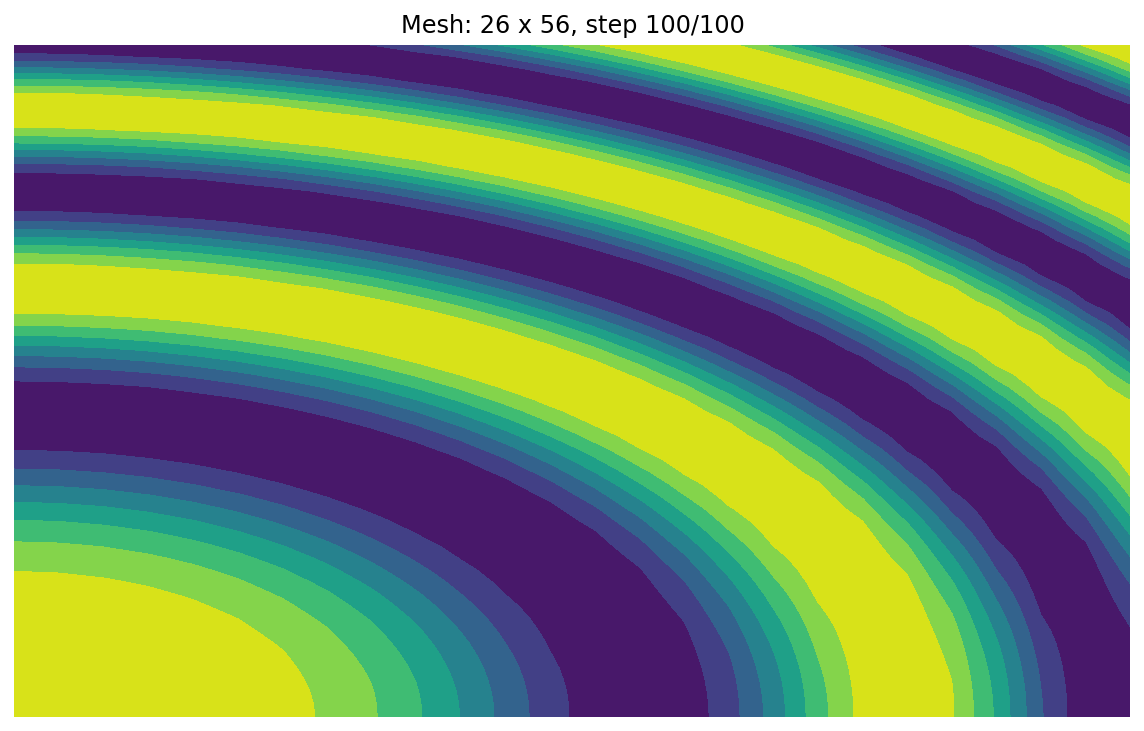

Simulation completed!
Monitored for: 0:00:11.457755.


In [10]:
monitor_simulation(ar, refresh=1)